# Tutorial 2

## Extraction of Radial Velocity Time Series using Different Methods

This tutorial demonstrates how `ARVE` can be used to extract radial velocity (RV) time series with the cross-correlation function (CCF) and line-by-line (LBL) techniques.

We begin by importing the `ARVE` package and other useful packages.

In [1]:
# Import packages
import arve
import matplotlib.pyplot as     plt
from   matplotlib.ticker import AutoMinorLocator
import numpy             as     np
import pandas            as     pd

For our analysis, we make use of a synthetic stellar spectral time series computed in [`Tutorial 0`](https://arve.readthedocs.io/en/latest/tutorials/tutorial_0.html) and downloadable [here](https://github.com/almoulla/arve/tree/main/docs/tutorials/example_data).

The spectral time series consists of 100 observations each containing the same 100 spectral lines. 95% of the lines are displaced with a sinusoidal signal of 10 m/s amplitude, whereas the remaining 5% of the lines are randomly shifted by RVs drawn from a $\mathcal{G}(\mu=100\,\mathrm{m/s}, \sigma=100\,\mathrm{m/s})$ distribution acting as spurious outliers (from, e.g., telluric contamination). The spectra are thereafter noised to a S/N of 200.

We begin by reading the true RVs of the sinusoidal signal.

In [2]:
# Read true RVs
df = pd.read_csv("example_data/tutorial_2/vrad.csv")
time_val      = df["time_val"     ].values
vrad_val_true = df["vrad_val_good"].values

For the RV extraction, we begin with the CCF technique.

An `ARVE` object is initiated and some relevant information about the input spectra is provided:
- `path`: relative path to the spectra (saved in individual files)
- `format`: whether the spectra are echelle-order merged (`"s1d"`) or echelle-order separated (`"s2d"`)
- `extension`: the extension of the files that the spectra are saved in (acceptable extensions are `"fits"`, `"npz"` and `"csv"`); if `"fits"`, additionally the `instrument` keyword must be specified; if `"npz"` or `"csv"`, the wavelength, flux and flux uncertainty variables must be named `wave_val`, `flux_val` and `flux_err`
- `medium`: medium of the recorded wavelengths
- `resolution`: spectral resolution, $\lambda/\Delta\lambda$, of the spectrum
- `same_wave_grid`: whether the spectra are recorded/interpolated onto the same wavelength grid

For the CCF computation, in this case, we notably do not exclude lines affected by tellurics (because there are none in the synthetic data), and we weigh the CCF by the RV information per line.

In [3]:
# Compute CCF RVs
example = arve.ARVE()
example.star.target = "Sun"
example.star.get_stellar_parameters()
example.data.add_data(path="example_data/tutorial_2/", format="s1d", extension="npz", medium="vac", resolution=100000, same_wave_grid=True)
example.data.get_aux_data()
example.data.compute_vrad_ccf(exclude_tellurics=False, vrad_grid=[-20,20,1], ccf_err_scale=True, weight_name="vrad_info")

# Extract CCF RVs
time_val     = example.data.time["time_val"]
vrad_val_ccf = example.data.vrad["vrad_val"]
vrad_err_ccf = example.data.vrad["vrad_err"]

Analyzed spectra:


100%|██████████| 100/100 [00:00<00:00, 269.41it/s]


Next, we move onto the LBL technique.

The steps are similar to the CCF technique, with the notable addition that a reference spectrum (sometime called a template) must first be built from all input spectra.

In addition to the average RVs, the LBL technique also provides the per-line RVs and an optional mask that can be applied to remove outlier lines.

Note:
The LBL function can also be used to compute part-by-part (PBP) RVs of line segments formed within a specified range of average formation temperatures, as described in [Al Moulla et al. (2022)](https://doi.org/10.1051/0004-6361/202243276). This is done by provding the `compute_vrad_lbl()` function with the `bins` keyword consisting of a list of ranges. For example `bins=[[5000,5500],[5500,6000]]` computes the PBP RVs between 5000-5500 K and 5500-6000 K.

In [4]:
# Compute LBL RVs
example = arve.ARVE()
example.star.target = "Sun"
example.star.get_stellar_parameters()
example.data.add_data(path="example_data/tutorial_2/", format="s1d", extension="npz", medium="vac", resolution=100000, same_wave_grid=True)
example.data.get_aux_data()
example.data.compute_spec_reference()
example.data.compute_vrad_lbl(exclude_tellurics=False, vrad_err_lim=0)

# Extract LBL RVs (weighted average)
time_val     = example.data.time["time_val"]
vrad_val_lbl = example.data.vrad["vrad_val"]
vrad_err_lbl = example.data.vrad["vrad_err"]

# Extract LBL RVs (per-line RVs before and after outlier rejection)
vrad_val_lbl_before = example.data.vrad["vrad_val_lbl"][0].flatten()
vrad_val_lbl_after  = example.data.vrad["vrad_val_lbl"][0][example.data.vrad["vrad_mask_lbl"][0]]

Analyzed spectra:


100%|██████████| 100/100 [00:03<00:00, 32.08it/s]


We convert the RVs from km/s to m/s for easier interpretation.

In [5]:
# Convert from km/s to m/s
vrad_val_true       *= 1e3
vrad_val_ccf        *= 1e3
vrad_err_ccf        *= 1e3
vrad_val_lbl        *= 1e3
vrad_err_lbl        *= 1e3
vrad_val_lbl_before *= 1e3
vrad_val_lbl_after  *= 1e3

Now that we have RVs from two different methods, we can compare them. We can see that the CCF RVs are more scattered around the true curve compared to the LBL RVs.

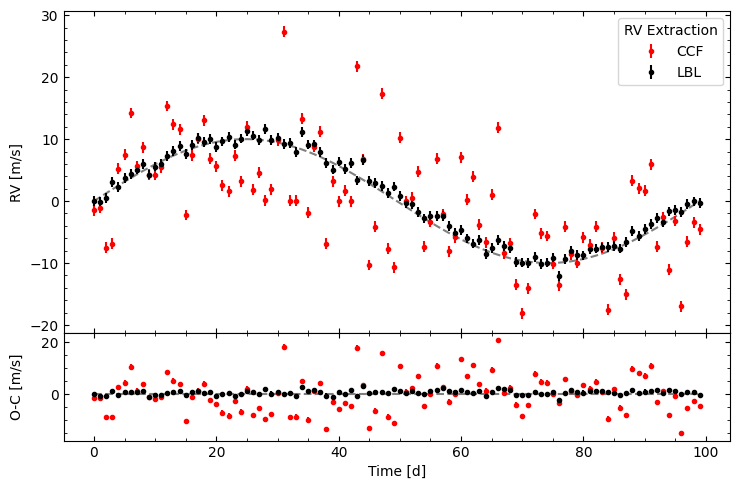

In [6]:
# Plot comparison between CCF and LBL RVs
fig, axs = plt.subplots(2, 1, height_ratios=[3,1], figsize=(7.5,5.0))

ax = axs[0]
ax.plot    (time_val, vrad_val_true, ls="--", color="k", alpha=0.5)
ax.errorbar(time_val, vrad_val_ccf-np.nanmedian(vrad_val_ccf), vrad_err_ccf, fmt=".", color="r", ecolor="r", label="CCF")
ax.errorbar(time_val, vrad_val_lbl-np.nanmedian(vrad_val_lbl), vrad_err_lbl, fmt=".", color="k", ecolor="k", label="LBL")
ax.legend(title="RV Extraction", loc="upper right")
ax.set_xticklabels([])
ax.set_ylabel("RV [m/s]")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

ax = axs[1]
ax.plot    (time_val, np.zeros_like(time_val), ls="--", color="k", alpha=0.5)
ax.errorbar(time_val, vrad_val_ccf-np.nanmedian(vrad_val_ccf)-vrad_val_true, vrad_err_ccf, fmt=".", color="r", ecolor="r", label="CCF")
ax.errorbar(time_val, vrad_val_lbl-np.nanmedian(vrad_val_lbl)-vrad_val_true, vrad_err_lbl, fmt=".", color="k", ecolor="k", label="LBL")
ax.set_xlabel("Time [d]")
ax.set_ylabel("O-C [m/s]")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

fig.align_ylabels()
fig.tight_layout()
fig.subplots_adjust(hspace=0)

fig.show()

Furthermore, if we analyse the per-line RVs (from all observations), we can see that the LBL method allows the identification and removal of outliers originating from a different distribution than the primary.

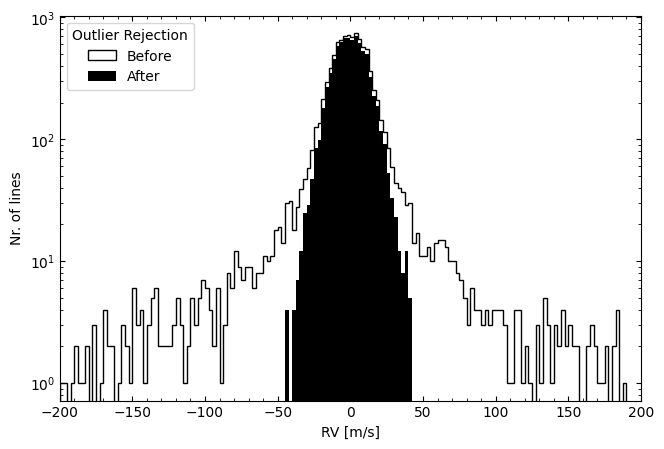

In [7]:
# Plot comparison between per-line RVs before and after outlier rejection
bins = np.arange(-200.0,200.1,2.5)
plt.figure(figsize=(7.5,5.0))
plt.hist(vrad_val_lbl_before, bins=bins, histtype="step", color="k", label="Before")
plt.hist(vrad_val_lbl_after , bins=bins, histtype="bar" , color="k", label="After" )
plt.legend(title="Outlier Rejection", loc="upper left")
plt.xlabel("RV [m/s]")
plt.ylabel("Nr. of lines")
plt.xlim(bins[0],bins[-1])
plt.yscale("log")
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().tick_params(axis="both", which="both", direction="in", top=True, right=True)
plt.show()